In [113]:
from typing import Callable
from collections import namedtuple
from copy import deepcopy as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

##### слои

###### линейный

In [197]:
class NNLinear:
    wb: np.ndarray
    inputs: np.ndarray
    optimizer: str
    grad_pre: np.ndarray = None
    H: np.ndarray = None
    wb_pre: np.ndarray = None

    def __init__(self, in_len, out_len, optimizer, perceptron):
        self.wb = np.random.rand(in_len+1, out_len)-0.5
        self.optimizer = optimizer
        self.perceptron = perceptron

    def __repr__(self):
        return f'NNLinear({self.wb.shape})'

    def __eq__(self, o):
        return id(self) == id(o)

    def forward(self, inputs: np.ndarray):
        '''
        inputs - вектор-строка длинны in_len
        '''
        # print(f'    -> forward in {self}')
        self.inputs = np.append(inputs, [1])
        return self.inputs @ self.wb

    def simple_forward(self, inputs: np.ndarray):
        '''
        inputs - вектор-строка длинны in_len
        '''
        return np.append(inputs, [1]) @ self.wb

    def simple_backward(self, grad):
        return (grad @ self.wb.T)[:-1]

    def backward(self, grad):
        # print(f'BACKWARD IN {self}')
        # вычисляем градиент, который прокинем
        # до шага оптимизатора
        grad_to_ret = (grad @ self.wb.T)[:-1]  # отрезаем градиент для bias
        # считаем градиент относительно параметров слоя
        grad_wb = np.reshape(self.inputs, (-1, 1)) @ np.reshape(grad, (1, -1))
        # нормируем!!!
        if np.linalg.norm(grad_wb) != 0:
            grad_wb = grad_wb/np.linalg.norm(grad_wb)

        if np.linalg.norm(grad_to_ret) != 0:
            grad_to_ret = grad_to_ret/np.linalg.norm(grad_to_ret)

        match self.optimizer:
            case 'GD':
                d = grad_wb
            case 'FR':
                # первый шаг
                if self.grad_pre is None:
                    self.grad_pre = grad_wb
                    b = 0
                # обычный шаг
                else:
                    grad = grad_wb.flatten()
                    grad_pre = self.grad_pre.flatten()
                    if np.linalg.norm(grad_pre) > 0.00001:
                        b = (np.sum(grad*grad)/np.sum(grad_pre*grad_pre))**2
                    else:
                        b = 1
                    b = max(min(b, 1), 0)
                    # если предыдущий градиент был нулевой, то не учитываем его
                    # if np.isnan(b) or b == np.Inf:
                    #     b = 0
                    # b = 0.1
                # считаем направление смещения
                d = (grad_wb + b*self.grad_pre)
                # запоминаем "старый" градиент
                self.grad_pre = grad_wb
            case 'BFGS':
                # https://github.com/kthohr/optim/blob/master/src/unconstrained/bfgs.cpp
                # инициализация
                if self.H is None:
                    self.H = np.identity(len(grad_wb))
                    self.grad_pre = np.zeros(grad_wb.shape)
                    self.wb_pre = np.zeros(self.wb.shape)

                # считаем направление смещения
                d = (self.H @ grad_wb)

                # обновляем гессиан
                y = grad_wb - self.grad_pre
                s = self.wb - self.wb_pre

                W1 = np.eye(len(grad_wb)) - s @ y.T
                self.H = W1 @ self.H @ W1.T

                # запоминаем "старые" значения
                self.grad_pre = grad_wb
                self.wb_pre = self.wb
            case _:
                raise RuntimeError('unknown optimizing method')

        # линейный поиск
        # нормируем d

        # print('start linear search')
        if np.linalg.norm(d) > 0.001:
            d = LR * d / np.linalg.norm(d)
        

        # self.wb -= d
        # return grad_to_ret

        def calc_special():
            return self.perceptron.calc_for_special_layer(self, self.inputs[:-1])

        old_res_val = calc_special()
        # print(f'    {old_res_val}')
        self.wb -= d
        new_res_val = calc_special()
        # print(f'    {new_res_val}')
        if new_res_val < old_res_val and abs(new_res_val - old_res_val) > 0.0001:
            while new_res_val < old_res_val and abs(new_res_val - old_res_val) > 0.0001:
                self.wb -= d
                old_res_val = new_res_val
                new_res_val = calc_special()
                # print(f'    {new_res_val}')
            self.wb += d

        # прокидываем градиент дальше
        return grad_to_ret
        # return self.perceptron.fit_special_layer_get_my_grad(self, self.inputs[:-1])

###### функции

In [115]:
relu = np.vectorize(lambda x: x if x > 0 else 0)
der_relu = np.vectorize(lambda x: 1 if x > 0 else 0)


class NNRelu:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return relu(inputs)

    def backward(self, grad):
        res = grad * der_relu(self.inputs)
        return res


def sigmoid(x): return 1/(1+np.exp(-x))
def der_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))


class NNSigmoid:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return sigmoid(inputs)

    def backward(self, grad):
        res = grad * der_sigmoid(self.inputs)
        return res

In [116]:
import warnings
warnings.filterwarnings("error")


def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x)/(np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


class NNSoftmax:
    inputs: np.ndarray

    def forward(self, inputs):
        self.inputs = inputs
        return softmax(inputs)

    def backward(self, grad):
        res = grad * softmax(self.inputs)*(1-softmax(self.inputs))
        return res

###### лосс

In [117]:
LossFunc = namedtuple('LossFunc', ['f', 'df', 'name'])

In [118]:
def mse(x, y): return sum((x-y)**2)/len(x)


def der_mse(x, y):
    res = (x-y)*2/len(x)*-1
    return res / np.sum(np.abs(res))


MSE = LossFunc(mse, der_mse, 'MSE LOSS')

In [119]:
def cross_entropy(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    return -np.mean(target * np.log(pred))


def der_cross_entropy(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    res = pred - target
    return res / np.linalg.norm(res)


CrossEntropy = LossFunc(cross_entropy, der_cross_entropy, 'Cross Entropy LOSS')

In [120]:
def kl(target, pred):
    pred = np.clip(pred, 1e-10, 1 - 1e-10)
    target = np.clip(pred, 1e-10, 1 - 1e-10)
    res = np.mean(target * np.log(target/pred))
    return res


def der_kl(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    res = pred - target
    return res / np.linalg.norm(res)


KLDiv = LossFunc(kl, der_kl, 'Kullback–Leibler Divergence LOSS')

###### оптимизаторы

In [121]:
GD = 'GD'
FR = 'FR'
BFGS = 'BFGS'

###### модель

In [122]:
class Perceptron:
    layers: list
    loss: LossFunc
    last_target: np.ndarray | None

    def __init__(self, sizes: list[int], loss, optimizer):
        self.layers = [
            x for i, o in zip(sizes, sizes[1:]+[10]) for x in [NNLinear(i, o, optimizer, self), NNSigmoid()]
        ] + [NNSoftmax()]
        self.loss = loss

    def forward(self, inputs):
        res = inputs
        for layer in self.layers:
            res = layer.forward(res)
        return res

    def backward(self, target, pred):
        grad_by_last_layer_outs = self.loss.df(target, pred)
        grad = grad_by_last_layer_outs
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, x, y):
        self.last_target = y
        pred = self.forward(x)
        self.backward(y, pred)
        return np.argmax(pred)

    def predict(self, x, y):
        pred = self.forward(x)
        return np.argmax(pred)

    def calc_for_special_layer(self, layer: NNLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(
                layer) != NNLinear else layer.simple_forward(res)
        return self.loss.f(self.last_target, res)

    def fit_special_layer_get_my_grad(self, layer: NNLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(
                layer) != NNLinear else layer.simple_forward(res)
        grad_by_last_layer_outs = self.loss.df(self.last_target, res)
        grad = grad_by_last_layer_outs
        for layer in self.layers[index:][::-1]:
            grad = layer.backward(grad) if type(
                layer) != NNLinear else layer.simple_backward(res)
        return grad

###### данные

In [123]:
ds = datasets.MNIST(
    root='data',
    train=True,
    download=True,

    transform=lambda img: np.array(np.asarray(img).flatten())/256,
    target_transform=lambda x: np.array(
        [1 if i == x else 0 for i in range(10)])
)
ds1 = Subset(ds, range(0, 1000))
dl1 = DataLoader(ds1, shuffle=True, batch_size=None)

ds2 = Subset(ds, range(1000, 1000+100))
dl2 = DataLoader(ds2, shuffle=True, batch_size=None)

##### Тренируем

###### функции тренировки

In [189]:
ACC = []

def train_epoch(model):
    results = 0
    for X, y in dl1:
        X, y = np.array(X), np.array(y)
        pred = model.fit(X, y)
    for X, y in dl2:
        X, y = np.array(X), np.array(y)
        pred = model.predict(X, y)
        results += (np.argmax(y) == pred)
    return results/len(dl2)


def train_many_epochs(model, N):
    global ACC
    accuracy = []
    for _ in tqdm(range(N)):
        a = train_epoch(model)
        print(a)
        accuracy.append(a)
        ACC = accuracy
    return accuracy

###### тренировка

In [164]:
def demo(optim, loss, lr, epochs):
    global LR
    LR = lr
    p = Perceptron(
        [784] + [64] + [10],
        optim,
        loss
    )
    accuracy = train_many_epochs(p, epochs)
    plt.plot(np.arange(len(accuracy)), accuracy)
    return accuracy

100%|██████████| 60/60 [01:57<00:00,  1.96s/it]


0.824

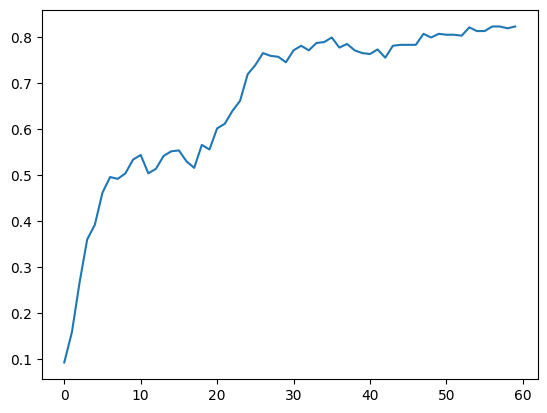

In [126]:
mse_res = demo(MSE, GD, 0.009, 60)
max(mse_res)

100%|██████████| 60/60 [01:45<00:00,  1.75s/it]


0.886

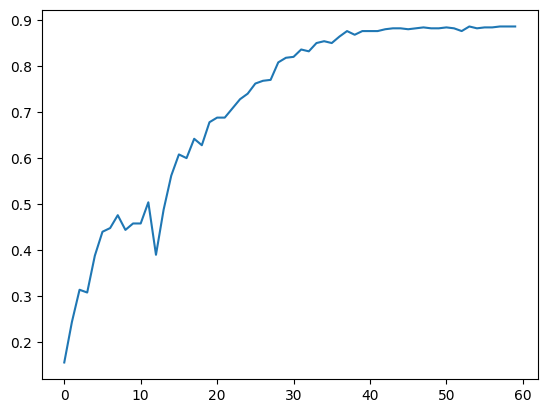

In [127]:
ce_res = demo(CrossEntropy, GD, 0.009, 60)
max(ce_res)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


NameError: name 'mzx' is not defined

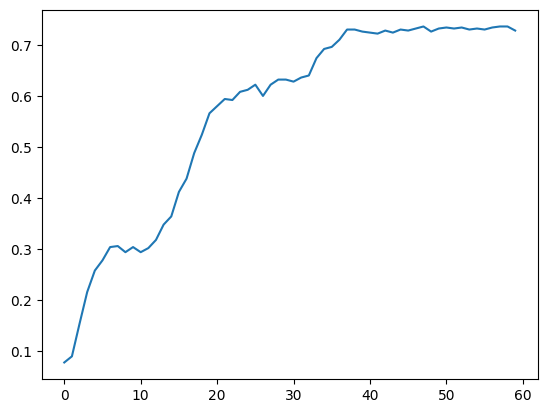

In [128]:
kld_res = demo(KLDiv, GD, 0.009, 60)

In [130]:
max(kld_res)

0.736

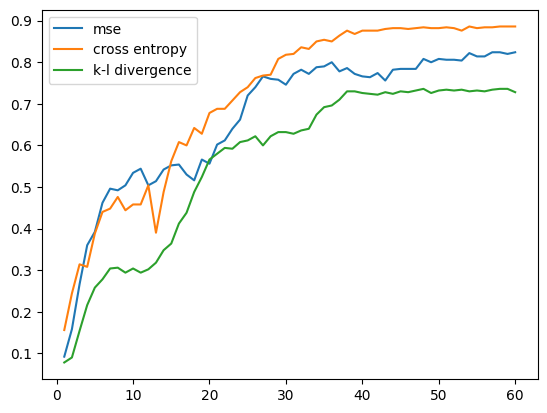

In [134]:
plt.plot(range(1, 61), mse_res, label='mse')
plt.plot(range(1, 61), ce_res, label='cross entropy')
plt.plot(range(1, 61), kld_res, label='k-l divergence')
plt.legend()
plt.show()

  2%|▎         | 1/40 [00:02<01:39,  2.55s/it]

0.102


  5%|▌         | 2/40 [00:05<01:41,  2.66s/it]

0.138


  8%|▊         | 3/40 [00:07<01:27,  2.37s/it]

0.174


 10%|█         | 4/40 [00:09<01:21,  2.27s/it]

0.26


 12%|█▎        | 5/40 [00:11<01:14,  2.12s/it]

0.296


 15%|█▌        | 6/40 [00:13<01:14,  2.19s/it]

0.296


 18%|█▊        | 7/40 [00:15<01:07,  2.04s/it]

0.346


 20%|██        | 8/40 [00:17<01:01,  1.92s/it]

0.45


 22%|██▎       | 9/40 [00:18<00:57,  1.85s/it]

0.468


 25%|██▌       | 10/40 [00:20<00:56,  1.88s/it]

0.526


 28%|██▊       | 11/40 [00:22<00:53,  1.84s/it]

0.518


 30%|███       | 12/40 [00:24<00:53,  1.92s/it]

0.486


 32%|███▎      | 13/40 [00:26<00:51,  1.89s/it]

0.526


 35%|███▌      | 14/40 [00:28<00:50,  1.93s/it]

0.54


 38%|███▊      | 15/40 [00:31<00:59,  2.39s/it]

0.51


 40%|████      | 16/40 [00:36<01:11,  2.97s/it]

0.5


 42%|████▎     | 17/40 [00:40<01:19,  3.45s/it]

0.54


 45%|████▌     | 18/40 [00:46<01:28,  4.04s/it]

0.562


 48%|████▊     | 19/40 [00:51<01:32,  4.38s/it]

0.664


 50%|█████     | 20/40 [00:57<01:38,  4.91s/it]

0.706


 52%|█████▎    | 21/40 [01:01<01:28,  4.68s/it]

0.742


 55%|█████▌    | 22/40 [01:05<01:22,  4.58s/it]

0.768


 57%|█████▊    | 23/40 [01:09<01:14,  4.38s/it]

0.772


 60%|██████    | 24/40 [01:13<01:05,  4.07s/it]

0.766


 62%|██████▎   | 25/40 [01:15<00:53,  3.54s/it]

0.78


 65%|██████▌   | 26/40 [01:17<00:44,  3.16s/it]

0.79


 68%|██████▊   | 27/40 [01:19<00:36,  2.79s/it]

0.796


 70%|███████   | 28/40 [01:21<00:31,  2.64s/it]

0.802


 72%|███████▎  | 29/40 [01:24<00:30,  2.73s/it]

0.81


 75%|███████▌  | 30/40 [01:27<00:28,  2.81s/it]

0.838


 78%|███████▊  | 31/40 [01:30<00:25,  2.89s/it]

0.86


 80%|████████  | 32/40 [01:33<00:21,  2.74s/it]

0.872


 82%|████████▎ | 33/40 [01:35<00:18,  2.70s/it]

0.88


 85%|████████▌ | 34/40 [01:39<00:16,  2.81s/it]

0.88


 88%|████████▊ | 35/40 [01:41<00:13,  2.79s/it]

0.896


 90%|█████████ | 36/40 [01:46<00:13,  3.30s/it]

0.924


 92%|█████████▎| 37/40 [01:49<00:09,  3.29s/it]

0.918


 95%|█████████▌| 38/40 [01:52<00:06,  3.08s/it]

0.92


 98%|█████████▊| 39/40 [01:54<00:02,  2.96s/it]

0.938


100%|██████████| 40/40 [01:58<00:00,  2.96s/it]

0.934


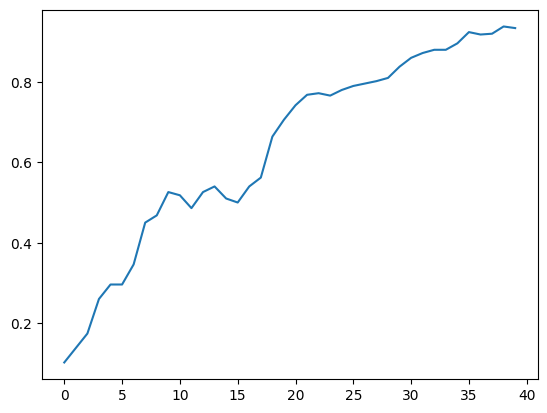

In [183]:
gd_res = demo(CrossEntropy, GD, 0.009, 40)

In [205]:
max(gd_res)

0.938

  2%|▎         | 1/40 [00:02<01:40,  2.59s/it]

0.088


  5%|▌         | 2/40 [00:05<01:43,  2.72s/it]

0.124


  8%|▊         | 3/40 [00:08<01:39,  2.70s/it]

0.14


 10%|█         | 4/40 [00:11<01:46,  2.95s/it]

0.228


 12%|█▎        | 5/40 [00:15<01:57,  3.36s/it]

0.284


 15%|█▌        | 6/40 [00:21<02:23,  4.22s/it]

0.524


 18%|█▊        | 7/40 [00:27<02:39,  4.82s/it]

0.596


 20%|██        | 8/40 [00:33<02:51,  5.36s/it]

0.688


 22%|██▎       | 9/40 [00:40<02:57,  5.72s/it]

0.724


 25%|██▌       | 10/40 [00:47<03:01,  6.04s/it]

0.79


 28%|██▊       | 11/40 [00:51<02:40,  5.52s/it]

0.828


 30%|███       | 12/40 [00:55<02:25,  5.19s/it]

0.842


 32%|███▎      | 13/40 [00:59<02:07,  4.71s/it]

0.87


 35%|███▌      | 14/40 [01:02<01:47,  4.15s/it]

0.924


 38%|███▊      | 15/40 [01:05<01:38,  3.93s/it]

0.922


 40%|████      | 16/40 [01:08<01:24,  3.53s/it]

0.944


 42%|████▎     | 17/40 [01:11<01:17,  3.39s/it]

0.94


 45%|████▌     | 18/40 [01:14<01:12,  3.31s/it]

0.96


 48%|████▊     | 19/40 [01:17<01:04,  3.07s/it]

0.952


 50%|█████     | 20/40 [01:19<00:56,  2.85s/it]

0.954


 52%|█████▎    | 21/40 [01:21<00:49,  2.63s/it]

0.962


 55%|█████▌    | 22/40 [01:23<00:44,  2.50s/it]

0.954


 57%|█████▊    | 23/40 [01:25<00:40,  2.40s/it]

0.954


 60%|██████    | 24/40 [01:27<00:35,  2.25s/it]

0.958


 62%|██████▎   | 25/40 [01:30<00:35,  2.35s/it]

0.956


 65%|██████▌   | 26/40 [01:32<00:33,  2.39s/it]

0.952


 68%|██████▊   | 27/40 [01:34<00:29,  2.25s/it]

0.968


 70%|███████   | 28/40 [01:36<00:25,  2.15s/it]

0.972


 72%|███████▎  | 29/40 [01:38<00:23,  2.13s/it]

0.968


 75%|███████▌  | 30/40 [01:40<00:20,  2.05s/it]

0.972


 78%|███████▊  | 31/40 [01:42<00:17,  2.00s/it]

0.972


 80%|████████  | 32/40 [01:44<00:15,  1.98s/it]

0.974


 82%|████████▎ | 33/40 [01:46<00:13,  1.96s/it]

0.976


 85%|████████▌ | 34/40 [01:48<00:11,  1.93s/it]

0.974


 88%|████████▊ | 35/40 [01:50<00:09,  1.90s/it]

0.976


 90%|█████████ | 36/40 [01:52<00:08,  2.11s/it]

0.974


 92%|█████████▎| 37/40 [01:55<00:06,  2.25s/it]

0.97


 95%|█████████▌| 38/40 [01:57<00:04,  2.15s/it]

0.974


 98%|█████████▊| 39/40 [01:59<00:02,  2.06s/it]

0.976


100%|██████████| 40/40 [02:00<00:00,  3.02s/it]

0.974


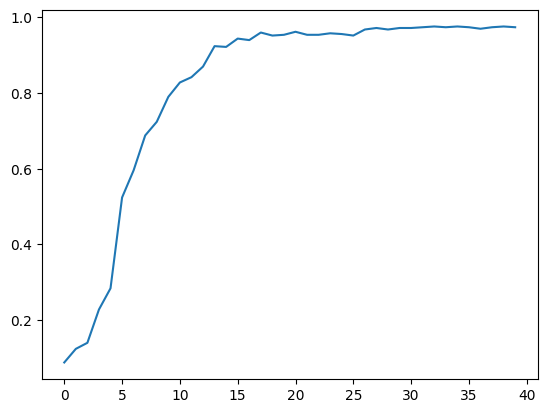

In [203]:
fr_res = demo(CrossEntropy, FR, 0.0085, 40)

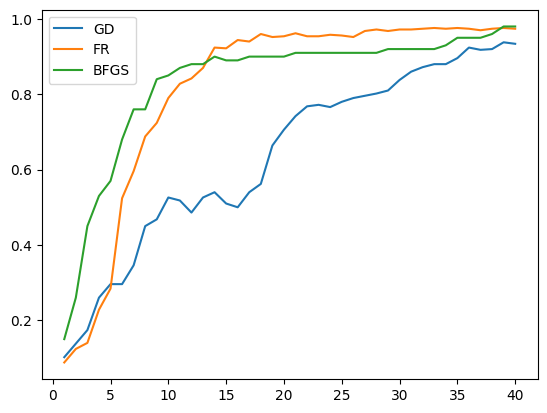

In [204]:
plt.plot(range(1, 41), gd_res, label='GD')
plt.plot(range(1, 41), fr_res, label='FR')
plt.plot(range(1, 41), bfgs_res, label='BFGS')
plt.legend()
plt.show()